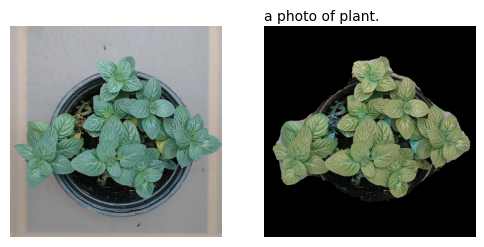

In [4]:
import requests
from PIL import Image
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation

img_path = r"C:\code\LEC-SWproject\02_leaf_segmentation\samples\01.jpg"
image = Image.open(img_path)

prompts = ["a photo of plant."]
image = image.convert('RGB')
tensor = torch.tensor(np.array(image)).permute(2, 0, 1).unsqueeze(0).float()

processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")

inputs = processor(text=prompts, images=[image] * len(prompts), padding="max_length", return_tensors="pt")
# predict
with torch.no_grad():
  outputs = model(**inputs)
preds = outputs.logits.unsqueeze(1)
masks = torch.sigmoid(preds).squeeze(1)
maskss = outputs.logits

fig, axs = plt.subplots(1, len(prompts) + 1, figsize=(3*(len(prompts) + 1), 4))
axs[0].imshow(image)
axs[0].axis('off')
for i, prompt in enumerate(prompts):
    # Get the heat map for the prompt
    heat_map = torch.sigmoid(preds[i][0]).detach().cpu().numpy()
    # Resize the heat map to match the original image size
    heat_map_resized = cv2.resize(heat_map, (image.size[0], image.size[1]))
    # Apply a threshold to the heat map to get the mask
    mask = (heat_map_resized > 0.5).astype(np.uint8)
    # Apply the mask to the original image
    masked_image = cv2.bitwise_and(np.array(image), np.array(image), mask=mask)
    
    masked_image = cv2.cvtColor(masked_image, cv2.COLOR_RGB2BGR)
    cv2.imwrite(f'segmented_object.png', masked_image)
    # Display the masked image
    axs[i+1].imshow(masked_image)
    axs[i+1].axis('off')
    axs[i+1].text(0, -15, prompt)
plt.show()